# Sensivity by race by domain visit frequencies

Questions we ask here:

- Are there demographic (by race) differences in browsing behavior?

t-closeness is one way of examining sensitivity.

Here we look at sensitivity by race based on overall domain visitation frequency.


chi-sq test of homogeneity: How we do it.

we have r populations: {white, black, asian, other}

preprocessing:
use raw sessions data after removing bad domains

make map 

{ machine_id: {domain: visits for each domain visited by machine} }

over all 52 weeks of data

table:

```
machine_id, domain, visits
```

where machine_id is duplicated for each domain the machine visited.



our category is domain.

we have D levels of our category, where D is the threshold number of most frequently visited domains.


if we didn't use panel data

Total sample is the size of our comscore data samples total: 



In [16]:
from datetime import datetime
import sys
sys.path.append('..')

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from itertools import chain, combinations
from collections import Counter


from comscore.data import read_weeks_machines_domains, read_comscore_demo_df

TOP_N_DOMAINS = 50

A core question left unanswered by our analysis of FLoC's sensitivity is whether racial groups in our dataset exhibit significant browsing behavior differences. If users' browsing history does not vary by racial group, then we should expect any clustering algorithm, including FLoC, to group independently of race. We use a Chi-Squared homogeneity test to test if racial groups' browsing behaviors are independent from race, treating each racial group as a separate population, and the top domains visited in our dataset as the categorical variable of interest. To calculate domain visit frequencies, we construct a set $D_w^m$ consisting of each unique domain visited by a machine $m$ in a given week $w$. 

In [6]:
# read in the pre-processed sessions data 
# this maps week,machine_id -> domains set
weeks_machines_domains_fpath = '../output/weeks_machines_domains.csv'
weeks_machines_domains_df = read_weeks_machines_domains(weeks_machines_domains_fpath)

reading from ../output/weeks_machines_domains.csv...
... read 4877236 rows


In [7]:
comscore_demo_df = (read_comscore_demo_df(fpath="../data/comscore/2017/demographics.csv", year=2017)
           .assign(machine_id=lambda x: x.machine_id.astype(int))
          )

df = (weeks_machines_domains_df.merge(comscore_demo_df, 
               how='inner', # only include machine_ids with valid data (no nan race)
               left_on='machine_id', 
               right_on='machine_id')
      .query("n_domains > 0")
     )
# convert to list
df.domains = [list(d) for d in df.domains]

In [8]:
df.head()

,machine_id,week,n_domains,domains,household_income,racial_background
0,169007206,1,104,"[azz-overload.net, guim.co.uk, ytimg.com, mang...",2.0,2.0
1,169007206,2,78,"[campuslabs.com, peperet.com, ytimg.com, manga...",2.0,2.0
2,169007206,3,77,"[alibaba.com, mangastream.com, iris.tv, chance...",2.0,2.0
3,169007206,4,53,"[amazon.com, mangastream.com, wikipedia.org, g...",2.0,2.0
4,169007206,5,47,"[amazon.com, freelibrary.org, spwickstrom.com,...",2.0,2.0


In [11]:
# Calculate frequencies for each race group
# takes a couple mins on my mac mini
start_time = datetime.now()
freqs = []
for race in df.racial_background.unique():
    df2 = df[df.racial_background == race]
    counter = pd.Series(Counter(chain.from_iterable(df2.domains)))
    freqs.append(counter)

end_time = datetime.now()
time = end_time - start_time
print('took %s' % (time))

took 0:00:31.275651


In [ ]:
races = df.racial_background.unique()
dfs = [(pd.DataFrame(distribution)
       .assign(race=races[i])) for i, distribution in enumerate(freqs)]

race_distributions = (pd.concat(dfs)
                      .reset_index()
                      .rename({'index': 'domain', 0: 'count'}, axis=1)
                     )
total_counts = race_distributions.groupby('race')['count'].sum()

race_distributions['p'] = race_distributions.apply(lambda x: x['count']/total_counts[x['race']], axis=1)

In [61]:
race_distributions.head()

,domain,count,race,p
0,azz-overload.net,118,2.0,0.000013
1,guim.co.uk,127,2.0,0.000014
2,ytimg.com,1798,2.0,0.000205
3,mangastream.com,227,2.0,0.000026
4,clipart-library.com,833,2.0,0.000095


In [62]:
all_distribution = (race_distributions
 .drop(['race', 'p'], axis=1)
 .groupby('domain')
 .aggregate({'count': sum})
 .assign(p=lambda x: x['count'] / x['count'].sum())
)
all_distribution.sort_values('p', ascending=False).head()

,count,p
domain,,
google.com,1411233,0.023044
yahoo.com,947341,0.015469
bing.com,940938,0.015365
msn.com,923215,0.015075
facebook.com,852397,0.013919


In [63]:
# top N domains overall
top_domains = all_distribution.nlargest(TOP_N_DOMAINS, columns='p')
top_domains['p'] = top_domains['count'] / top_domains['count'].sum()
top_domains.head()

,count,p
domain,,
google.com,1411233,0.120317
yahoo.com,947341,0.080767
bing.com,940938,0.080221
msn.com,923215,0.078710
facebook.com,852397,0.072672


Aggregating across weeks for each racial group, this gives us a distribution over all domains in our dataset. For example, here are the top 5 domains visited by each racial group in the comscore data:

In [64]:
(race_distributions
 .groupby('race')
 .apply(lambda x: x.nlargest(5, columns='p'))
)

domain   count  race         p
race                                              
1.0  1737037    google.com  890981   1.0  0.021858
     1736868     yahoo.com  610559   1.0  0.014978
     1737502      bing.com  610519   1.0  0.014977
     1738435       msn.com  605949   1.0  0.014865
     1737027  facebook.com  573936   1.0  0.014080
2.0  25         google.com  212673   2.0  0.024243
     108          bing.com  164125   2.0  0.018709
     155         yahoo.com  153909   2.0  0.017545
     55            msn.com  151281   2.0  0.017245
     79        youtube.com  129046   2.0  0.014710
3.0  5110015    google.com  112510   3.0  0.024931
     5110629   youtube.com   71889   3.0  0.015930
     5110767     yahoo.com   65815   3.0  0.014584
     5110776  facebook.com   56309   3.0  0.012478
     5110396       msn.com   50662   3.0  0.011226
5.0  909349     google.com  195069   5.0  0.027118
     910130       bing.com  118151   5.0  0.016425
     909367      yahoo.com  117058   5.0  0.016273
     909393    youtube.com  116542   5.0  0.016201
     910100        msn.com  115323   5.0  0.016032

To calculate our Chi-Square statistics, we limit our analysis to the top 50 domains across all racial groups. Our contingency table consists of each domain as a "category" and each racial group as a separate population:

In [65]:
from scipy.stats import chisquare, chi2_contingency

race_dist_df = race_distributions[race_distributions.domain.isin(top_domains.index)]

race_X = (race_dist_df
 [['domain', 'race', 'count']]
 .pivot(index='domain', columns='race')
          # calc frequencies
)
race_X.head()

count                     
race            1.0    2.0    3.0    5.0
domain                                  
247-inc.net  106272  19239  10103  17613
adobe.com     60001  14965   7311  12332
amazon.com   360901  58566  40463  58887
aol.com      137061  21109   8078  18480
apple.com     49895  14188   7216  10932

Rather than using Chi-Square to test whether all groups are from the same underlying distribution, we construct a series of pairwise Chi-Square tests to test if any two racial groups exhibit similar browsing behavior. We find that each racial group's browsing distributions are significantly different from the overall population:

In [43]:
df = race_X['count']
results = []
for col in df.columns:
    df = race_X['count']
    col = 1.0
    X = pd.concat([df[col], top_domains['count']], axis=1).values
    results.append(chi2_contingency(X))
#    chi2, p, dof, ex = chi2_contingency(X)

[r[1] for r in results] # p-values

[0.0, 0.0, 0.0, 0.0]

And then comparing pairwise between racial groups, we find that each group's distribution is significantly different from each other group:

In [41]:
pairs = combinations([c[1] for c in race_X.columns], r=2)

df = race_X['count']
results = []
for c1, c2 in pairs:
    df = race_X['count']
    col = 1.0
    X = pd.concat([df[c1], df[c2]], axis=1).values
    results.append(chi2_contingency(X))
#    chi2, p, dof, ex = chi2_contingency(X)

[r[1] for r in results] # p-values

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [75]:
# don't need this
# expected_X = top_domains.count
chi2, p, dof, ex = chi2_contingency(race_X.values)

---

While the Chi-Square test demonstrates that there *is* a difference in browsing behavior between racial groups, it doesn't show the degree of that difference. To get a sense for differences in behavior, two plots displaying distributions over domain frequencies are below. The first is grouped, which gives a better sense of overall domains, and the second is faceted, which provides a sense of the actual differences in shape:

In [96]:
race_dist_df = (race_distributions[race_distributions.domain.isin(top_domains.index)]
                # should sum to 1
                .assign(p = lambda x: x.p / x.groupby('race').transform('sum')['p'])
               )

race_X = (race_dist_df
 [['domain', 'race', 'count']]
 .pivot(index='domain', columns='race')
          # calc frequencies
)
race_X.head()

count                     
race            1.0    2.0    3.0    5.0
domain                                  
247-inc.net  106272  19239  10103  17613
adobe.com     60001  14965   7311  12332
amazon.com   360901  58566  40463  58887
aol.com      137061  21109   8078  18480
apple.com     49895  14188   7216  10932

In [109]:
from plotnine import (ggplot, geom_point, aes, stat_smooth, 
                      facet_wrap, geom_bar, element_text, 
                      theme, theme_minimal, labs, element_blank)

# Organize data
race_values = {1:'white', 2:'black', 3:'asian', 5:'other', 6: 'any'}

plot_df = (pd.concat([(top_domains.reset_index()
                       .rename({'index': 'domain'}, axis=1)
                       .assign(race=6)), 
                      race_dist_df])
           # convert to readable strings, then categorical vars
           .assign(race = lambda x: x.race.astype(int).map(race_values))
           .assign(race=lambda x: pd.Categorical(x.race, categories=x.race.unique().sort()),
                   domain=lambda x: pd.Categorical(x.domain, categories=x.domain.unique()),
                   p=lambda x: x.p.astype(float))
          )

### Comparing "overall" distribution to each racial category:

any
black
other
white
asian


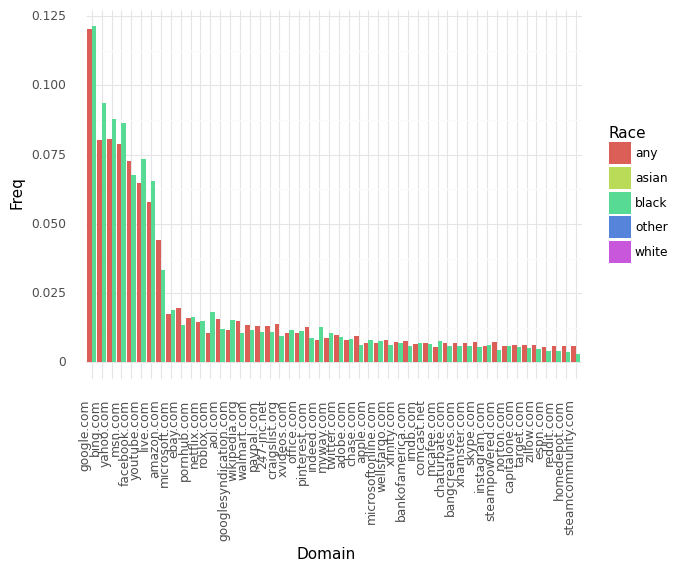

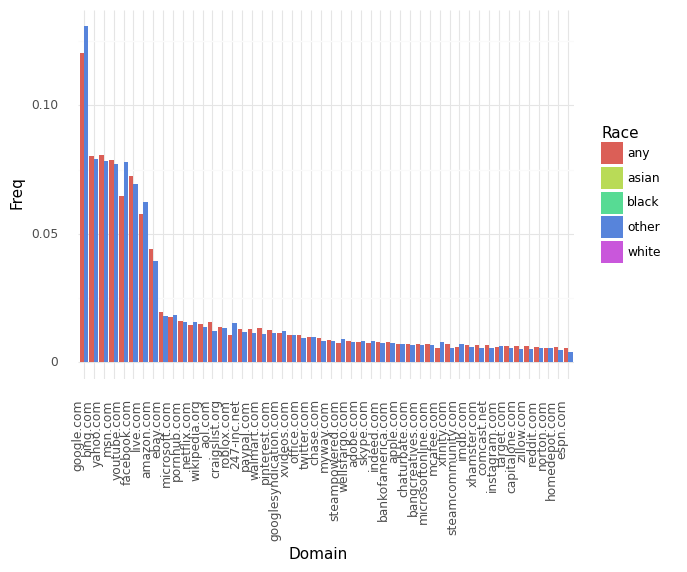

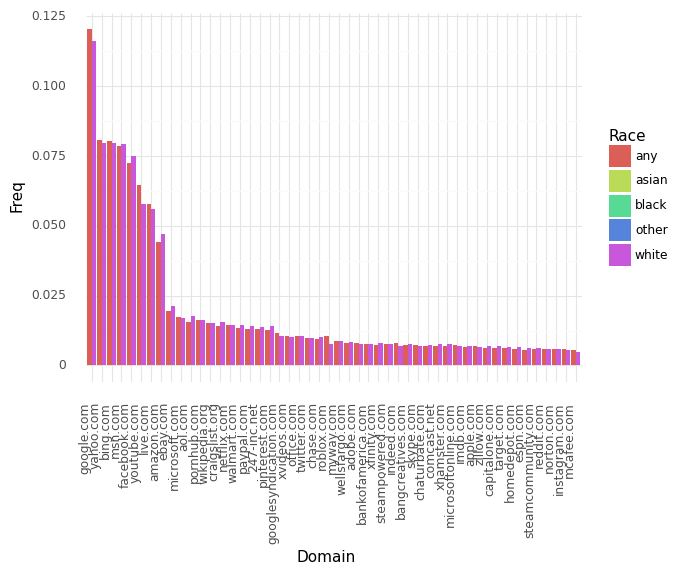

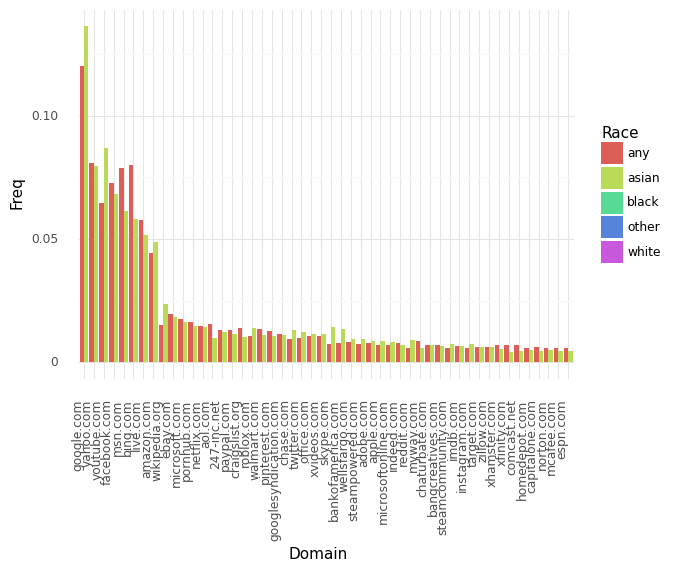

[<ggplot: (777100674)>,
 <ggplot: (779224540)>,
 <ggplot: (779265172)>,
 <ggplot: (779278737)>]

In [110]:
plots = []
for race in plot_df.race.unique():
    print(race)
    
    if race != 'any':
        plots.append((plot_df
         .query('race == @race | race == "any"')
         .pipe(lambda x:
             ggplot(x, aes(x='reorder(domain, -p)', y='p', fill='race')) +
             geom_bar(stat='identity', position='dodge') +
             theme_minimal() +
             theme(axis_text_x=element_text(angle=90, vjust=1, hjust=1)) +
             labs(x="Domain", y="Freq", fill="Race")
        )))
plots

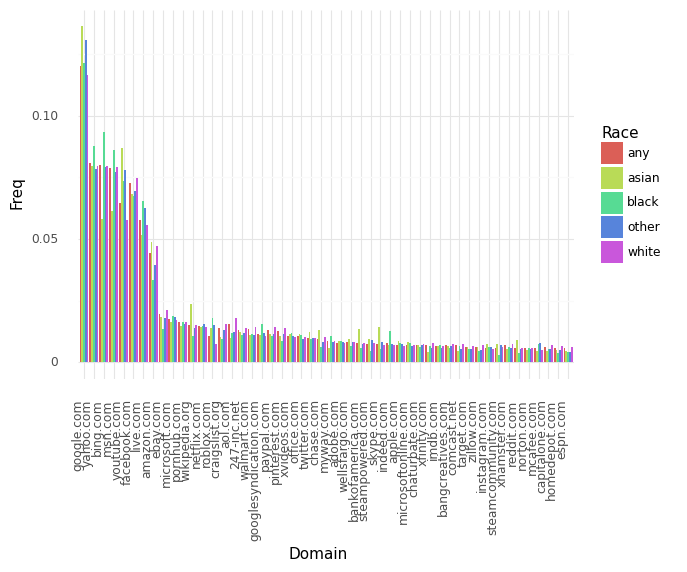

<ggplot: (779548395)>

In [111]:
(plot_df
 .pipe(lambda x:
     ggplot(x, aes(x='reorder(domain, -p)', y='p', fill='race')) +
     geom_bar(stat='identity', position='dodge') +
     theme_minimal() +
     theme(axis_text_x=element_text(angle=90, vjust=1, hjust=1)) +
     labs(x="Domain", y="Freq", fill="Race")
))

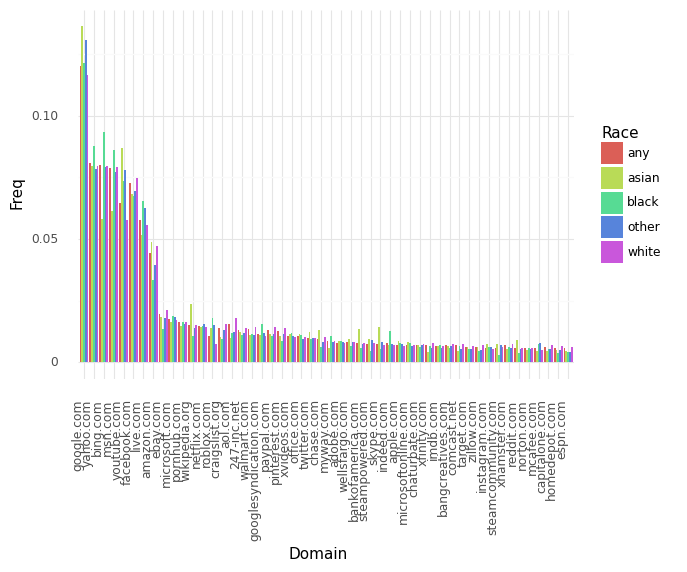

<ggplot: (781275248)>

In [116]:
(plot_df
 .pipe(lambda x:
     ggplot(x, aes(x='reorder(domain, -p)', y='p', fill='race')) +
     geom_bar(stat='identity', position='dodge') +
     theme_minimal() +
     theme(axis_text_x=element_text(angle=90, vjust=1, hjust=1)) +
     labs(x="Domain", y="Freq", fill="Race")
))

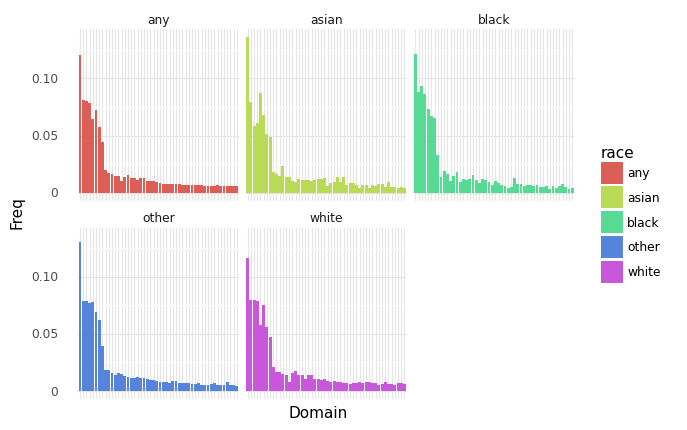

<ggplot: (782406163)>

In [118]:
(plot_df
 .pipe(lambda x:
     ggplot(x, aes(x='reorder(domain, -p)', y='p', fill='race')) +
     geom_bar(stat='identity', position='dodge') +
     theme_minimal() +
     theme(axis_text_x=element_blank()) +
     labs(x="Domain", y="Freq") +
       facet_wrap('~race')
))

Although the distributions are generally shaped similarly, there are significant differences in overall frequencies to the top few sites overall.